In [1]:
using Plots, ProgressMeter, CUDA, JLD2

In [2]:
E = load("Filter_matrices.jld2")
h_Eki = E["Eki"]
h_Eik = E["Eik"]
;

In [3]:
# Simulation parameters
nx=65
ny=nx
ncells=nx*ny

iterations=50
savingperiod=1
u0 = 0.1f0
ρ0 = 1.0f0
Re = 1000.0f0
ν = (nx-1)*u0/Re # Kinematic viscosity (0.005 <= ν <= 0.2)

println("ν = ", ν)

# Directions
C=1; E=2; S=3; W=4; N=5; NE=6; SE=7; SW=8; NW=9
dx = Int8[0, 1, 0, -1, 0, 1, 1, -1, -1]
dy = Int8[0, 0, -1, 0, 1, 1, -1, -1, 1]
w = Float32[4f0/9f0, 1f0/9f0, 1f0/9f0, 1f0/9f0, 1f0/9f0,
              1f0/36f0, 1f0/36f0, 1f0/36f0, 1f0/36f0]

opposite = Int8[1, 4, 5, 2, 3, 8, 9, 6, 7]

# Geometry
geometry=ones(Int, nx, ny)    # Wall cells
geometry[2:nx-1,2:ny-1] .= 0  # fluid cells
geometry[:,ny] .= 2           # Top lid cells

geom_lin = vec(geometry)
;

ν = 0.0064000003


In [4]:
# Host side distribution functions
h_fmin = zeros(Float32, 9, ncells)
h_fplus = similar(h_fmin)
h_αmin = similar(h_fmin)
h_αplus = similar(h_fmin)

# Initial distribution set at equilibrium
h_fmin[C, :] .= ρ0 * (4f0/9f0)
for d in (E, S, W, N)
    h_fmin[d, :] .= ρ0 * (1f0/9f0)
end
for d in (NE, SE, SW, NW)
    h_fmin[d, :] .= ρ0 * (1f0/36f0)
end

# Move data over to GPU
fmin = CuArray(h_fmin)
fplus = CuArray(h_fplus)
αmin = CuArray(h_αmin)
αplus = CuArray(h_αplus)
geom_d = CuArray(Int32.(geom_lin))
Eik = CuArray(h_Eik)
Eki = CuArray(h_Eki)

ρ_d = CuArray(zeros(Float32, ncells))
ux_d  = CuArray(zeros(Float32, ncells))
uy_d  = CuArray(zeros(Float32, ncells))

nx_d = Int32(nx)
ny_d = Int32(ny)
ncells_d = Int32(ncells)

# Precompute dx, dy, opposite arrays on GPU
w_d = CuArray(w)
dx_d = CuArray(Int8.(dx))
dy_d = CuArray(Int8.(dy))
opp_d = CuArray(Int8.(opposite))
;

In [5]:
# GPU kernels
function collision_kernel!(fmin::CuDeviceMatrix{Float32}, fplus::CuDeviceMatrix{Float32}, 
        αmin::CuDeviceMatrix{Float32}, αplus::CuDeviceMatrix{Float32}, Eki::CuDeviceMatrix{Float32}, Eik::CuDeviceMatrix{Float32},
        w::CuDeviceVector{Float32}, ν::Float32, ncells::Int32)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if tid < 1 || tid > ncells
        return
    end
    
    idx = tid
    for k in 1:9
        acc = 0f0
        for i in 1:9
            acc += Eki[k, i] * fmin[i, idx]
        end
        αmin[k, idx] = acc
    end

    νfactor = -6*ν - 1

    αplus[1, idx] = αmin[1, idx]
    αplus[2, idx] = αmin[2, idx]
    αplus[3, idx] = αmin[3, idx]
    αplus[4, idx] = αmin[4, idx] + 2*(αmin[4, idx] - 3*αmin[2, idx]^2/αmin[1, idx])/νfactor
    αplus[5, idx] = αmin[5, idx] + 2*(αmin[5, idx] - 3*αmin[2, idx]*αmin[3, idx]/αmin[1, idx])/νfactor
    αplus[6, idx] = αmin[6, idx] + 2*(αmin[6, idx] - 3*αmin[3, idx]^2/αmin[1, idx])/νfactor
    αplus[7, idx] = 0
    αplus[8, idx] = 0
    αplus[9, idx] = 0

    for i in 1:9
        acc = 0f0
        for k in 1:9
            acc += w[i] * Eik[i, k] * αplus[k, idx]
        end
        fplus[i, idx] = acc
    end
    
    return
end

function streaming_kernel!(fmin::CuDeviceMatrix{Float32}, fplus::CuDeviceMatrix{Float32}, αplus::CuDeviceMatrix{Float32}, 
        geom::CuDeviceVector{Int32}, w::CuDeviceVector{Float32}, nx::Int32, ny::Int32, 
        ncells::Int32, dx_d::CuDeviceVector{Int8}, dy_d::CuDeviceVector{Int8}, opp_d::CuDeviceVector{Int8}, u0::Float32)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if tid < 1 || tid > ncells
        return
    end

    idx = tid
    j = (idx - 1) ÷ nx + 1
    i = (idx - 1) % nx + 1

    g = geom[idx]
    
    if (g == 1)
        # Wall cells
        for d in 1:9
            ddx = Int32(dx_d[d])
            ddy = Int32(dy_d[d])
            ni = i + ddx
            nj = j + ddy
            if (ni<1) || (ni>nx) || (nj<1) || (nj>ny)
                # Bounce back
                fmin[opp_d[d], idx] = fplus[d, idx]
            else
                # Normal flow
                nidx = (nj - 1) * nx + ni
                fmin[d, nidx] = fplus[d, idx]
            end
        end
        return
    end

    if (g == 2)
        # Top lid cells
        for d in 1:9
            ddx = Int32(dx_d[d])
            ddy = Int32(dy_d[d])
            ni = i + ddx
            nj = j + ddy
            if (ni<1) || (ni>nx) || (nj<1) || (nj>ny)
                ρ = αplus[1, idx]
                fmin[opp_d[d], idx] = fplus[d, idx] - 6*ρ*w[d]*ddx*u0
            else
                # Normal flow
                nidx = (nj - 1) * nx + ni
                fmin[d, nidx] = fplus[d, idx]
            end
        end
        return
    end

    for d in 1:9
        ddx = Int32(dx_d[d])
        ddy = Int32(dy_d[d])
        ni = i + ddx
        nj = j + ddy
        nidx = (nj - 1) * nx + ni
        fmin[d, nidx] = fplus[d, idx]
    end
    
    return
end

function saving_kernel!(ρ::CuDeviceVector{Float32}, ux::CuDeviceVector{Float32}, uy::CuDeviceVector{Float32}, 
        fmin::CuDeviceMatrix{Float32}, fplus::CuDeviceMatrix{Float32}, 
        dx_d::CuDeviceVector{Int8}, dy_d::CuDeviceVector{Int8}, ncells::Int32)
    tid = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if tid < 1 || tid > ncells
        return
    end
    idx = tid

    ρmin  = 0f0
    ρplus = 0f0
    uxmin  = 0f0
    uxplus = 0f0
    uymin  = 0f0
    uyplus = 0f0

    for i in 1:9
        ρmin += fmin[i, idx]
        ρplus += fplus[i, idx]

        uxmin += fmin[i, idx]*dx_d[i]
        uxplus += fplus[i, idx]*dx_d[i]

        uymin += fmin[i, idx]*dy_d[i]
        uyplus += fplus[i, idx]*dy_d[i]
    end

    uxmin /= ρmin
    uxplus /= ρplus
    uymin /= ρmin
    uyplus /= ρplus

    ρ[idx] = (ρmin + ρplus)/2
    ux[idx] = (uxmin + uxplus)/2
    uy[idx] = (uymin + uyplus)/2

    return
end
;

In [6]:
# kernel compilation helper
collision_gpu = @cuda threads=256 collision_kernel!(fmin, fplus, αmin, αplus, Eki, Eik, w_d, ν, ncells_d)

# main time loop
threads = 256
blocks = cld(ncells, threads)

u_list = []
ρ_list = []
@showprogress for it in 1:iterations
    @cuda threads=threads blocks=blocks collision_kernel!(fmin, fplus, αmin, αplus, Eki, Eik, w_d, ν, ncells_d)
    @cuda threads=threads blocks=blocks streaming_kernel!(fmin, fplus, αplus, geom_d, w_d, nx_d, ny_d, ncells_d, dx_d, dy_d, opp_d, u0)

    if (it % savingperiod) == 0
        @cuda threads=threads blocks=blocks saving_kernel!(ρ_d, ux_d, uy_d, fmin, fplus, dx_d, dy_d, ncells_d)

        CUDA.synchronize()

        ρ_h = Array(ρ_d)
        ux_h = Array(ux_d)
        uy_h = Array(uy_d)

        push!(ρ_list, reshape(ρ_h, nx, ny))
        push!(u_list, sqrt.(reshape(ux_h, nx, ny).^2 + reshape(uy_h, nx, ny).^2))
    end
    
    if (it % 1000) == 0
        CUDA.synchronize()
    end
end
CUDA.synchronize()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is 

Plots.AnimatedGif("/home/matspc/SSD/FMLB/TEMP.gif")
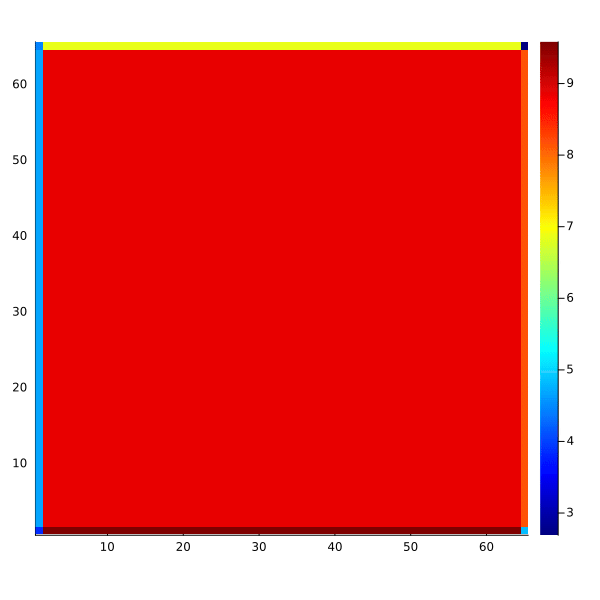

In [7]:
anim = @animate for t in 1:length(u_list)
    h = heatmap(u_list[t]'./u0, c=:jet, aspect_ratio=:equal)
    plot(h, size=(600,600))
end
gif(anim, "TEMP.gif", fps=10)

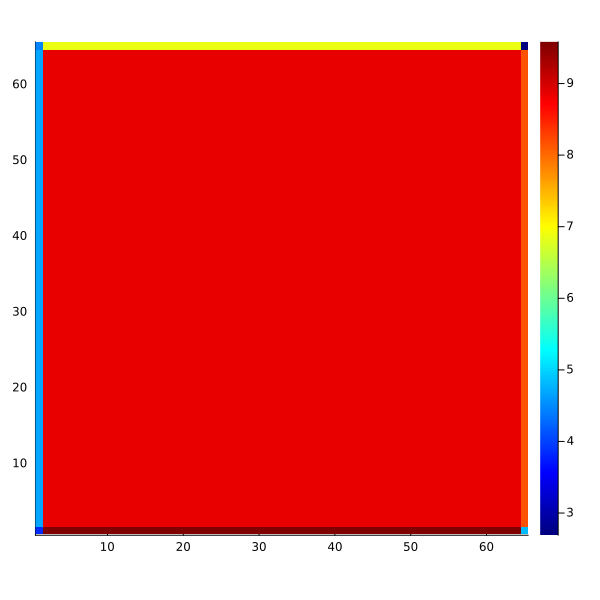

In [8]:
h = heatmap(u_list[1]'./u0, c=:jet, aspect_ratio=:equal)
plot(h, size=(600,600))

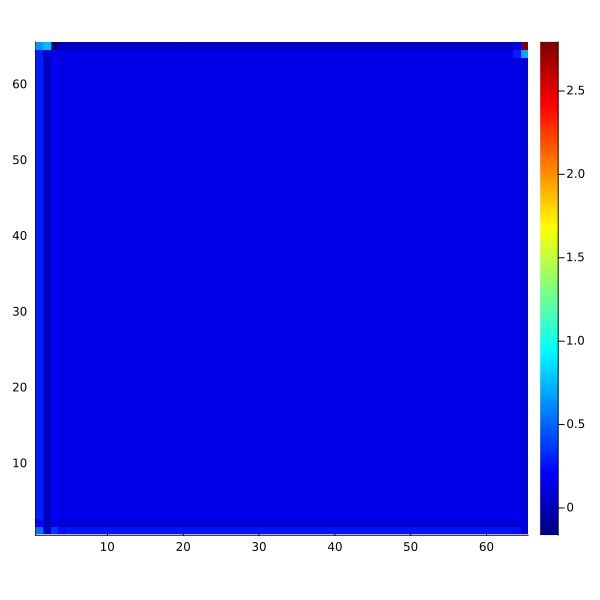

In [69]:
h = heatmap(ρ_list[5]', c=:jet, aspect_ratio=:equal)
plot(h, size=(600,600))

In [ ]:
Ek(i) = [1, dx[i], 3dx[i]*dy[i], 3dx[i]^2-1, dy[i], 3dy[i]^2-1, (3dx[i]^2-1)*(3dy[i]^2-1)/2, dy[i]*(3dx[i]^2-1), dx[i]*(3dy[i]^2-1)]
h_Eki = Float32.(Matrix([Ek(1) Ek(2) Ek(3) Ek(4) Ek(5) Ek(6) Ek(7) Ek(8) Ek(9)]'))

Ei(i) = [1, 3dx[i], 3dx[i]*dy[i], (3dx[i]^2-1)/2, 3dy[i], (3dy[i]^2-1)/2, (3dx[i]^2-1)*(3dy[i]^2-1)/2, 3dy[i]*(3dx[i]^2-1)/2, 3dx[i]*(3dy[i]^2-1)/2]
h_Eik = Float32.(Matrix([Ei(1) Ei(2) Ei(3) Ei(4) Ei(5) Ei(6) Ei(7) Ei(8) Ei(9)]))
;